In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

Read in and describe the data, with some quick visualisations.

In [90]:
hp = pd.read_csv("~/HW2/train.csv")
hp_test = pd.read_csv("~/HW2/test.csv")
hp.describe()
hp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [91]:
hp_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

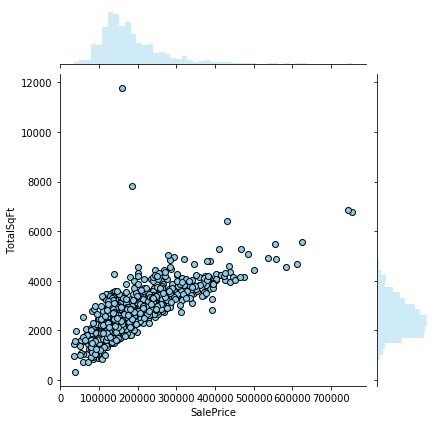

In [92]:
hp['TotalSqFt'] = hp['TotalBsmtSF'] + hp['1stFlrSF'] + hp['2ndFlrSF']
sns.jointplot(x = hp['SalePrice'], y = hp['TotalSqFt'], color = 'skyblue', edgecolor = 'black')

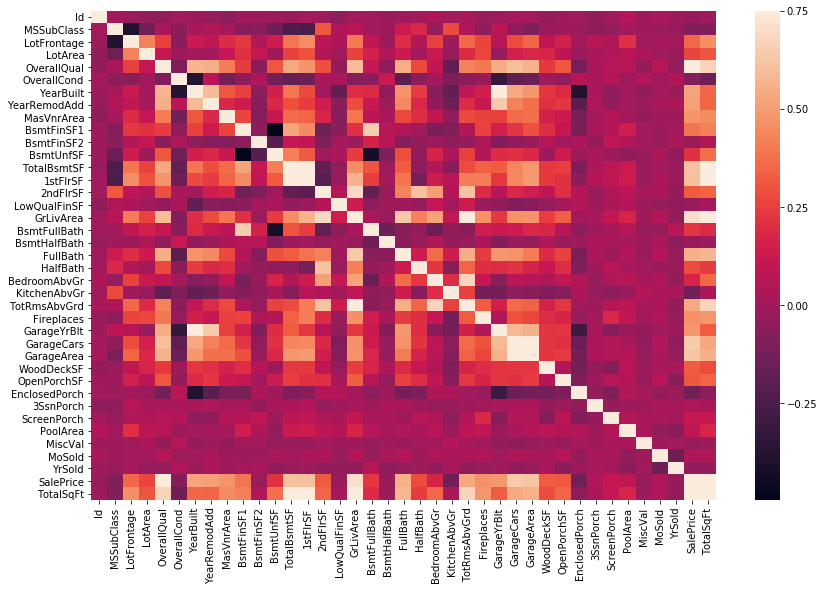

In [93]:
cov_matrix = hp.corr()
f, ax = plt.pyplot.subplots(figsize = (14,9))
sns.heatmap(cov_matrix, vmax = .75, square = False)

We can then take a look into the covariance matrix to see which features are significantly correlated with the sale price.

In [94]:
cov_matrix['SalePrice'].sort_values()

NameError: name 'cov_matrix' is not defined

1st Model: Using only the quantitative data.
Pull out most relevant values and scale them in a new data frame.

In [153]:
hp_test['TotalSqFt'] = hp_test['TotalBsmtSF'] + hp_test['1stFlrSF'] + hp_test['2ndFlrSF']

In [154]:
hp_target = hp['SalePrice']
hp_to_scale = hp[['OverallQual', 'TotalSqFt', 'GarageArea', 'GarageCars', 'FullBath', 'YearBuilt', 'LotArea']]
hp_test_to_scale = hp_test[['OverallQual', 'TotalSqFt', 'GarageArea', 'GarageCars', 'FullBath', 'YearBuilt', 'LotArea']]
#hp_test_to_scale = hp_test_to_scale.dropna()
hp_test_to_scale.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
OverallQual    1459 non-null int64
TotalSqFt      1458 non-null float64
GarageArea     1458 non-null float64
GarageCars     1458 non-null float64
FullBath       1459 non-null int64
YearBuilt      1459 non-null int64
LotArea        1459 non-null int64
dtypes: float64(3), int64(4)
memory usage: 79.9 KB


In [168]:
hp_test_to_scale[pd.isnull(hp_test_to_scale).any(axis=1)]
hp_test_to_scale = hp_test_to_scale.fillna(hp_test_to_scale.mean())
hp_test_to_scale[pd.isnull(hp_test_to_scale).any(axis=1)]

,OverallQual,TotalSqFt,GarageArea,GarageCars,FullBath,YearBuilt,LotArea


In [169]:
scaler = StandardScaler()
scaler.fit(hp_to_scale)
scaler.fit(hp_test_to_scale)
scaled_hp = scaler.transform(hp_to_scale)
scaled_hp_test = scaler.transform(hp_test_to_scale)

/home/thecheat/.miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/thecheat/.miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/thecheat/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/thecheat/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [170]:
hp_model = SGDRegressor(tol=.0001, eta0=.01)
hp_model.fit(scaled_hp, np.log(hp_target))
predictions = hp_model.predict(scaled_hp)
submit_pred = hp_model.predict(scaled_hp_test)
mse = mean_squared_error(np.log(hp_target), predictions)
print("RMSE: {}".format(np.sqrt(mse)))
interpret = pd.concat([hp_target, np.exp(pd.Series(predictions)), hp_target - np.exp(pd.Series(predictions))], axis = 1)
interpret.columns = ['LnSalePrice', 'Prediction', 'Difference']
interpret.describe()

RMSE: 0.17369501042329988


,LnSalePrice,Prediction,Difference
count,1460.000000,1.460000e+03,1.460000e+03
mean,180921.195890,1.776455e+05,3.275714e+03
std,79442.502883,7.387380e+04,4.547263e+04
min,34900.000000,5.360778e+04,-1.165855e+06
25%,129975.000000,1.272272e+05,-1.156236e+04
50%,163000.000000,1.632058e+05,1.838648e+03
75%,214000.000000,2.084977e+05,1.575601e+04
max,755000.000000,1.325855e+06,2.234803e+05


We can then look at each of the coefficients to determine which were the most relevant and impactful in determining our predictions.

In [120]:
sorted(list(zip(hp_to_scale.columns, hp_model.coef_)), key=lambda x: abs(x[1]))

[('GarageArea', -8.052303542752055e-05),
 ('FullBath', 0.013866515620815098),
 ('LotArea', 0.0323896906448858),
 ('YearBuilt', 0.06022785717745832),
 ('GarageCars', 0.06612833704161514),
 ('TotalSqFt', 0.1348288778755216),
 ('OverallQual', 0.15215111534785117)]

In [177]:
submission = pd.DataFrame(np.exp(submit_pred), columns = ['SalePrice'])
submission = pd.concat([hp_test['Id'], submission], axis = 1)
submission

,Id,SalePrice
0,1461,118322.649171
1,1462,151271.377000
2,1463,160451.715011
3,1464,177318.816425
4,1465,217183.016417
5,1466,172535.922669
6,1467,169943.099913
7,1468,169209.417718
8,1469,193537.771229
9,1470,116754.701190


Then we create the file for submission.

In [183]:
submission.to_csv("sub1.csv", sep=',')